In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [11]:
dataset = tf.data.Dataset.range(10)
for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [12]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [13]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [14]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [15]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [16]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
  print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[5 6 7 8] [9]
[1 2 3 4] [5]
[2 3 4 5] [6]
[4 5 6 7] [8]
[0 1 2 3] [4]


In [17]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[3 4 5 6]
 [0 1 2 3]]
y =  [[7]
 [4]]
x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
x =  [[1 2 3 4]
 [5 6 7 8]]
y =  [[5]
 [9]]


In [18]:
# Practice 2

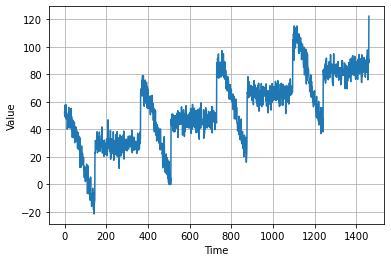

In [11]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [24]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 [==============================] - 0s 13ms/step - loss: 448.8436
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 189.4065
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 141.6869
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 124.5565
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 116.8770
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 110.6660
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 104.0803
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 100.0865
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 96.4480
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 92.6495
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 89.5868
Epoch 12/100
31

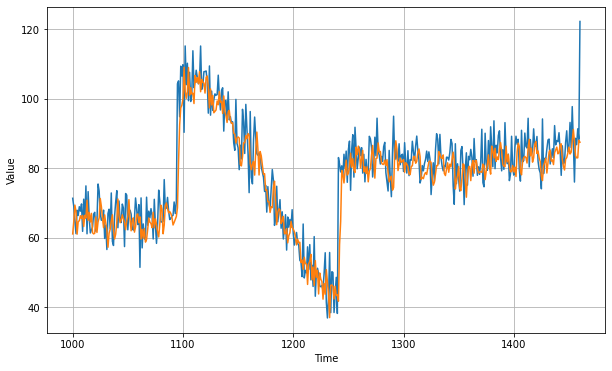

In [22]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.144989

In [1]:
# Practice 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # slice the time series data
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # window the data
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # take a dataset of datasets and flatten it into a single dataset:
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.00195411],
       [-0.02874514],
       [ 0.05415787],
       [-0.03223779],
       [-0.03509462],
       [-0.0193036 ],
       [ 0.05100621],
       [ 0.08489671],
       [-0.08958954],
       [ 0.00257658],
       [-0.03149997],
       [ 0.05405978],
       [-0.06634735],
       [ 0.08770672],
       [-0.02303372],
       [ 0.06379227],
       [ 0.01394848],
       [ 0.16236886],
       [ 0.23485085],
       [ 0.49210414]], dtype=float32), array([0.01513019], dtype=float32)]


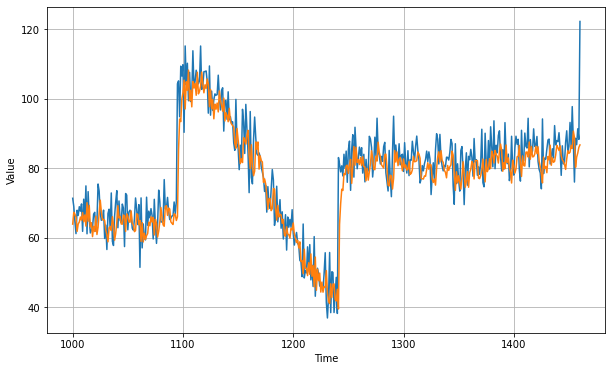

In [6]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2189655